# Разведочный анализ данных абитуриентов ИИК
### Дано: анонимизированная выгрузка данных о студентах, поступивших в ИИК.
### На выходе: Jupyter Notebook, иллюстрирующий выполненное задание, с графиками и пояснениями.
### Первичная обработка
1.	Сделать преобразование данных в графе «пол» - М=мужской, Ж=женский
2.	Вместо полей "информатика" и "физика" завести два поля: "3балл " и "3экз" - в одном балл по физике или информатике, в другом строка, в которой написан предмет, по которому сдан экзамен (физика или информатика).
3.	Баллы за индивидуальные достижения трансформировать в два булевых столбца: "олимпиада" и "медаль"
4.	"Школа" распарсить в поля "населённый пункт" и "школа", добиться как можно меньшего числа вариантов написания одной и той же школы
Можно п. 4 отложить на потом, если будет тягостно, сконцентрировавшись на анализе того, что хорошо парсится.
### Анализ датасета
Провести разведочный анализ данных с целью выявления неожиданных примеров корреляции признаков, желательно, касающихся выбора направления. Для основного анализа можно рассматривать только поступление на бюджет. Остальных можно вообще убрать из анализа.

Например, попробовать проанализировать:
#### •	Есть ли изменения в портрете поступающего на ИБАС (или ИИК в целом) со временем? (в распределении баллов, гендере и пр.)
#### •	Есть ли отличия студента, поступающего на ИБАС в сравнении с ПМИ или ФИИТ или ИВТ или ИИК в целом (школы, пропорции в баллах ЕГЭ, олимпиады, медали)?


## Обработка данных

In [122]:
import numpy as np
import pandas as pd
import re
import scipy.stats as sts
import statistics as st
import matplotlib.pyplot as plt
import math
plt.style.use('ggplot')

In [123]:
file_path = 'priem16_23.csv'  
data_frame = pd.read_csv(file_path, delimiter=';', dtype={
    'Сумма баллов': 'float64',
    'р.я': 'float64',
    'инф': 'float64',
    'мат': 'float64',
    'физ': 'float64',
    'Сумма баллов за индивидуальные достижения': 'float64',
    'Год поступления': 'int64'
})
data_frame['Пол'].replace({'М': 'Мужской', 'Ж': 'Женский'}, inplace=True)
data_frame.head()

,Пол,Нуждается в общежитии,Иностранное гражданство,Школа,Вид приема,Набор ОП,Сумма баллов,р.я,инф,мат,физ,Баллы за индивидуальные достижения,Сумма баллов за индивидуальные достижения,Год поступления
0,Мужской,нет,Казахстан,"""Интеллектуальная школа физико-математического...",Общий конкурс,10.03.01 Информационная безопасность,227.0,70.0,NaN,96.0,61.0,NaN,0.0,2019
1,Мужской,да,Нигерия,"""Колледж Notre Dame"" D'aArique Bietry, Кот Д'И...",По договору,10.03.01 Информационная безопасность,143.0,42.0,NaN,53.0,48.0,NaN,0.0,2018
2,Мужской,да,Казахстан,"""Общеобразовательная средняя школа №43"" отдела...",Общий конкурс,11.03.04 Электроника и наноэлектроника,190.0,65.0,NaN,76.0,49.0,NaN,0.0,2019
3,Мужской,нет,Казахстан,"""Средняя общеобразовательная школа №16"" города...",Общий конкурс,09.03.01 Информатика и вычислительная техника,232.0,73.0,NaN,96.0,63.0,NaN,0.0,2019
4,Мужской,да,Казахстан,"""Средняя общеобразовательная школа №7"" города ...",Общий конкурс,11.03.04 Электроника и наноэлектроника,189.0,75.0,NaN,56.0,48.0,1. Победитель/призер Международной предметной ...,10.0,2019


In [124]:
data_frame.insert(11, '3балл', [data_frame['инф'][i] if data_frame['инф'][i] > 0 else data_frame['физ'][i] for i in range(data_frame['физ'].size)] )
data_frame.insert(12, '3экз', ['Информатика' if number > 0 else 'Физика' for number in data_frame['инф']])
data_frame = data_frame.drop(columns=['инф', 'физ'])

data_frame.head()

,Пол,Нуждается в общежитии,Иностранное гражданство,Школа,Вид приема,Набор ОП,Сумма баллов,р.я,мат,3балл,3экз,Баллы за индивидуальные достижения,Сумма баллов за индивидуальные достижения,Год поступления
0,Мужской,нет,Казахстан,"""Интеллектуальная школа физико-математического...",Общий конкурс,10.03.01 Информационная безопасность,227.0,70.0,96.0,61.0,Физика,NaN,0.0,2019
1,Мужской,да,Нигерия,"""Колледж Notre Dame"" D'aArique Bietry, Кот Д'И...",По договору,10.03.01 Информационная безопасность,143.0,42.0,53.0,48.0,Физика,NaN,0.0,2018
2,Мужской,да,Казахстан,"""Общеобразовательная средняя школа №43"" отдела...",Общий конкурс,11.03.04 Электроника и наноэлектроника,190.0,65.0,76.0,49.0,Физика,NaN,0.0,2019
3,Мужской,нет,Казахстан,"""Средняя общеобразовательная школа №16"" города...",Общий конкурс,09.03.01 Информатика и вычислительная техника,232.0,73.0,96.0,63.0,Физика,NaN,0.0,2019
4,Мужской,да,Казахстан,"""Средняя общеобразовательная школа №7"" города ...",Общий конкурс,11.03.04 Электроника и наноэлектроника,189.0,75.0,56.0,48.0,Физика,1. Победитель/призер Международной предметной ...,10.0,2019


In [125]:
data_frame['Олимпиада'] = data_frame['Баллы за индивидуальные достижения'].str.contains(
    'олимпиад', case=False, na=False)
data_frame['Медаль'] = data_frame['Баллы за индивидуальные достижения'].str.contains(
    'с отличием', case=False, na=False)
data_frame = data_frame.drop(columns=['Баллы за индивидуальные достижения'])

data_frame.head()

,Пол,Нуждается в общежитии,Иностранное гражданство,Школа,Вид приема,Набор ОП,Сумма баллов,р.я,мат,3балл,3экз,Сумма баллов за индивидуальные достижения,Год поступления,Олимпиада,Медаль
0,Мужской,нет,Казахстан,"""Интеллектуальная школа физико-математического...",Общий конкурс,10.03.01 Информационная безопасность,227.0,70.0,96.0,61.0,Физика,0.0,2019,False,False
1,Мужской,да,Нигерия,"""Колледж Notre Dame"" D'aArique Bietry, Кот Д'И...",По договору,10.03.01 Информационная безопасность,143.0,42.0,53.0,48.0,Физика,0.0,2018,False,False
2,Мужской,да,Казахстан,"""Общеобразовательная средняя школа №43"" отдела...",Общий конкурс,11.03.04 Электроника и наноэлектроника,190.0,65.0,76.0,49.0,Физика,0.0,2019,False,False
3,Мужской,нет,Казахстан,"""Средняя общеобразовательная школа №16"" города...",Общий конкурс,09.03.01 Информатика и вычислительная техника,232.0,73.0,96.0,63.0,Физика,0.0,2019,False,False
4,Мужской,да,Казахстан,"""Средняя общеобразовательная школа №7"" города ...",Общий конкурс,11.03.04 Электроника и наноэлектроника,189.0,75.0,56.0,48.0,Физика,10.0,2019,True,False


In [126]:
def split_school_location(school_info):
    match = re.search(
        r'(.+),\s*((?:г\.|с\.|пгт\.|ж/д_ст\.|пос\.)\s*[^,]+)', school_info, re.IGNORECASE)
    if match:
        school = match.group(1).strip()
        city = match.group(2).strip()
        return school, city
    return school_info, ""


data_frame[['Образовательное учереждение', 'Населенный пункт']] = data_frame['Школа'].apply(lambda x: pd.Series(split_school_location(x)))
data_frame = data_frame.drop(columns=['Школа'])
data_frame.head()

,Пол,Нуждается в общежитии,Иностранное гражданство,Вид приема,Набор ОП,Сумма баллов,р.я,мат,3балл,3экз,Сумма баллов за индивидуальные достижения,Год поступления,Олимпиада,Медаль,Образовательное учереждение,Населенный пункт
0,Мужской,нет,Казахстан,Общий конкурс,10.03.01 Информационная безопасность,227.0,70.0,96.0,61.0,Физика,0.0,2019,False,False,"""Интеллектуальная школа физико-математического...",г. Уральск
1,Мужской,да,Нигерия,По договору,10.03.01 Информационная безопасность,143.0,42.0,53.0,48.0,Физика,0.0,2018,False,False,"""Колледж Notre Dame"" D'aArique Bietry, Кот Д'И...",г. Абиджан
2,Мужской,да,Казахстан,Общий конкурс,11.03.04 Электроника и наноэлектроника,190.0,65.0,76.0,49.0,Физика,0.0,2019,False,False,"""Общеобразовательная средняя школа №43"" отдела...",г. Уральск
3,Мужской,нет,Казахстан,Общий конкурс,09.03.01 Информатика и вычислительная техника,232.0,73.0,96.0,63.0,Физика,0.0,2019,False,False,"""Средняя общеобразовательная школа №16"" города...",г. Уральск
4,Мужской,да,Казахстан,Общий конкурс,11.03.04 Электроника и наноэлектроника,189.0,75.0,56.0,48.0,Физика,10.0,2019,True,False,"""Средняя общеобразовательная школа №7"" города ...",г. Уральск


 ## Первичный анализ

In [127]:
data_ibas = data_frame.copy()
data_ibas = data_ibas.loc[data_ibas['Вид приема'] == 'Общий конкурс']
data_ibas = data_ibas.loc[data_ibas['Набор ОП'] ==
                          '10.05.03 Информационная безопасность автоматизированных систем']
data_ibas

,Пол,Нуждается в общежитии,Иностранное гражданство,Вид приема,Набор ОП,Сумма баллов,р.я,мат,3балл,3экз,Сумма баллов за индивидуальные достижения,Год поступления,Олимпиада,Медаль,Образовательное учереждение,Населенный пункт
28,Женский,да,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,246.0,96.0,74.0,66.0,Физика,10.0,2019,True,False,"ГБНОУ Самарской области ""Академия для одаренны...",г. Самара (63)
38,Женский,нет,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,246.0,85.0,82.0,74.0,Физика,5.0,2019,False,True,"ГБНОУ Самарской области ""Самарский региональны...",г. Самара (63)
39,Женский,да,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,246.0,94.0,80.0,72.0,Физика,0.0,2019,False,False,"ГБНОУ Самарской области ""Самарский региональны...",г. Самара (63)
52,Мужской,нет,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,243.0,91.0,68.0,84.0,Физика,0.0,2018,False,False,"ГБОУ ВО Самарской области ""Самарская государст...",г. Самара (63)
67,Мужской,нет,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,235.0,89.0,74.0,72.0,Физика,0.0,2018,False,False,ГБОУ Самарской области гимназию №1 имени Н.И.Ф...,г. Новокуйбышевск (63)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816,Женский,нет,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,275.0,96.0,84.0,95.0,Информатика,0.0,2023,False,False,"МБОУ ""Школа № 12 имени Героя Советского Союза ...",г. Самара (63)
5824,Мужской,нет,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,242.0,81.0,76.0,85.0,Информатика,0.0,2023,False,False,"ГБОУ Самарской области СОШ ""Образовательный це...",
5829,Мужской,да,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,252.0,85.0,78.0,87.0,Физика,2.0,2023,False,False,"МБОУ ""Заглядинская средняя общеобразовательная...",
5832,Мужской,да,NaN,Общий конкурс,10.05.03 Информационная безопасность автоматиз...,230.0,66.0,76.0,88.0,Информатика,0.0,2023,False,False,ГБОУ Самарской области гимназию города Сызрани...,г. Сызрань (63)


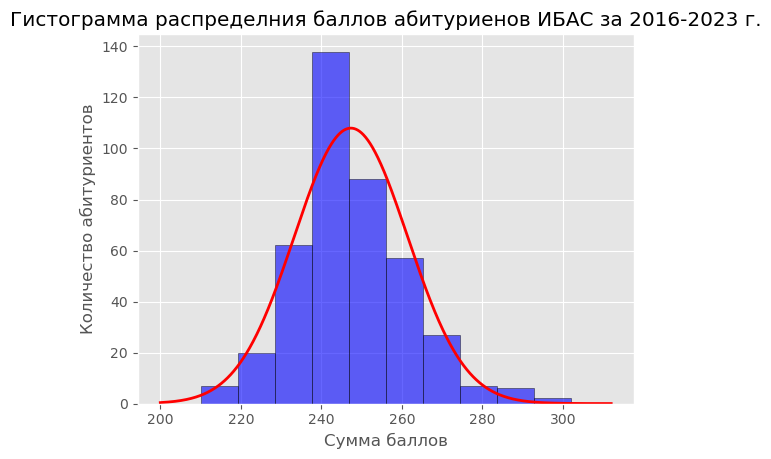

Средний балл поступающего за все время:  247.34299516908212
СКО баллов поступающего за все время:  14.07135840140696


In [128]:
points = data_ibas['Сумма баллов']
hist, edges = np.histogram(points)
plt.hist(points, edgecolor='black', color="blue", alpha=0.6)

x = np.linspace(min(points) - 10, max(points) + 10, 1000)
pdf = sts.norm.pdf(x, loc=np.mean(points), scale=np.std(points)) * points.size * (edges[1] - edges[0])

plt.plot(x, pdf, "r-", lw=2)
plt.title('Гистограмма распределния баллов абитуриенов ИБАС за 2016-2023 г.')
plt.xlabel('Сумма баллов')
plt.ylabel('Количество абитуриентов')
plt.show()
print('Средний балл поступающего за все время: ', np.mean(points))
print('СКО баллов поступающего за все время: ', np.std(points))

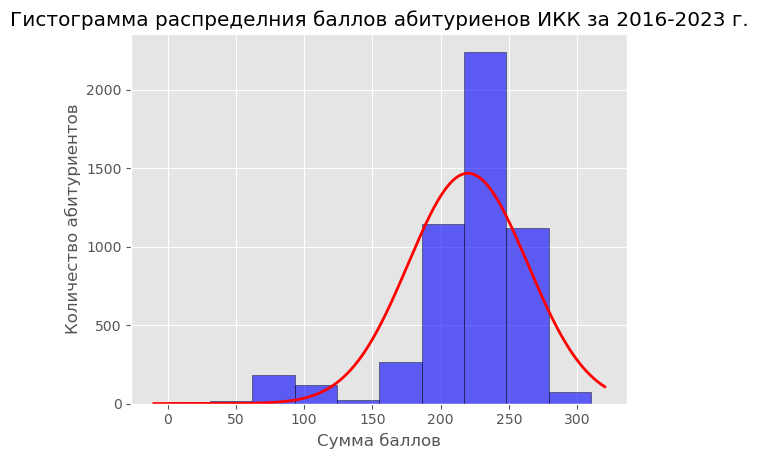

Средний балл поступающего за все время:  247.34299516908212
СКО баллов поступающего за все время:  14.07135840140696


In [129]:
data_iik = data_frame.loc[data_frame['Вид приема'] == 'Общий конкурс']
points_iik = data_iik['Сумма баллов']
hist, edges = np.histogram(points_iik)
plt.hist(points_iik, edgecolor='black', color="blue", alpha=0.6)

x = np.linspace(min(points_iik) - 10, max(points_iik) + 10, 1000)
pdf = sts.norm.pdf(x, loc=np.mean(points_iik), scale=np.std(
    points_iik)) * points_iik.size * (edges[1] - edges[0])

plt.plot(x, pdf, "r-", lw=2)
plt.title('Гистограмма распределния баллов абитуриенов ИКК за 2016-2023 г.')
plt.xlabel('Сумма баллов')
plt.ylabel('Количество абитуриентов')
plt.show()
print('Средний балл поступающего за все время: ', np.mean(points))
print('СКО баллов поступающего за все время: ', np.std(points))

c:\Users\User\.conda\envs\trash\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\.conda\envs\trash\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


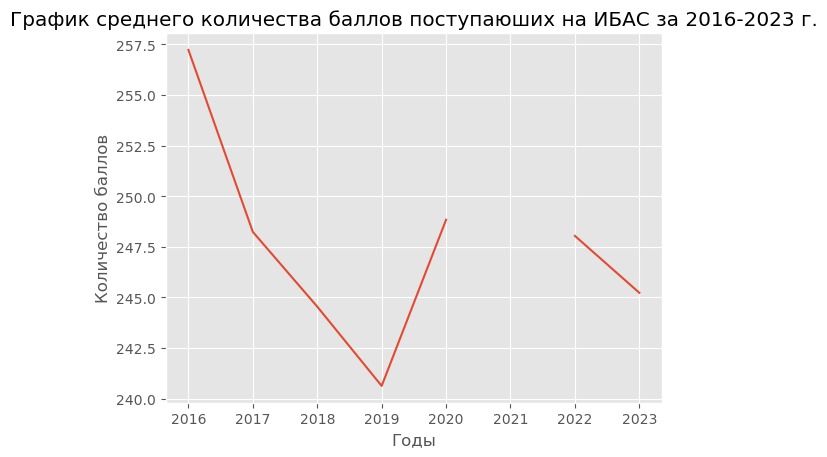

In [140]:
points_year = []
years = []
for i in range(2016, 2024):
    years.append(i)
    points_temp = data_ibas.loc[data_ibas['Год поступления'] == i]
    points_temp = points_temp['Сумма баллов'].values
    points_year.append(np.mean(points_temp))

plt.plot(years, points_year)
plt.title('График среднего количества баллов поступаюших на ИБАС за 2016-2023 г.')
plt.xlabel('Годы')
plt.ylabel('Количество баллов')
plt.show

c:\Users\User\.conda\envs\trash\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\.conda\envs\trash\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


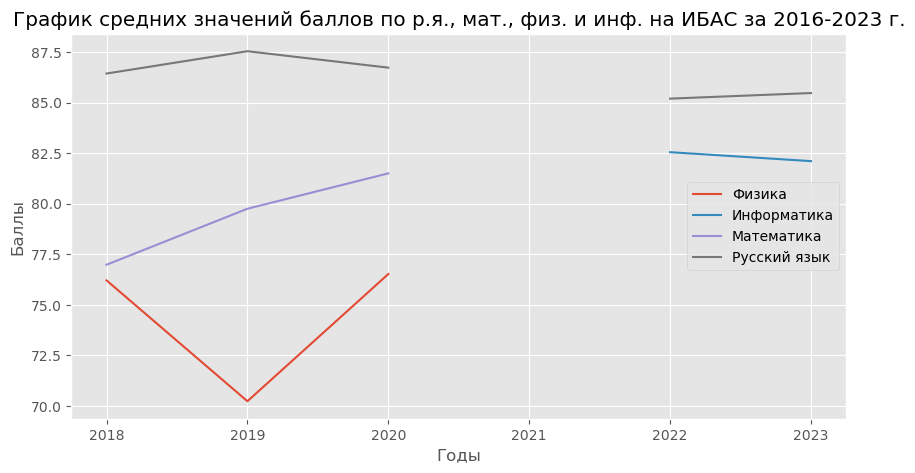

In [153]:
points_fiz_year = []
points_inf_year = []
points_rus_year = []
points_math_year = []
years = []
for i in range(2016, 2024):
    years.append(i)
    points_temp = data_ibas.loc[data_ibas['Год поступления'] == i]
    points_temp_values = points_temp['р.я'].values
    points_rus_year.append(np.mean(points_temp_values))
    points_temp_values = points_temp['мат'].values
    points_math_year.append(np.mean(points_temp_values))
    points_temp_inf = points_temp.loc[points_temp['3экз'] == 'Информатика']
    points_temp_values = points_temp_inf['3балл'].values
    points_inf_year.append(np.mean(points_temp_values))
    points_temp_fiz = points_temp.loc[points_temp['3экз'] == 'Физика']
    points_temp_values = points_temp_fiz['3балл'].values
    points_fiz_year.append(np.mean(points_temp_values))

plt.figure(figsize=(10,5))
plt.plot(years, points_fiz_year, label='Физика')
plt.plot(years, points_inf_year, label='Информатика')
plt.plot(years, points_math_year, label='Математика')
plt.plot(years, points_rus_year, label='Русский язык')
plt.title('График средних значений баллов по р.я., мат., физ. и инф. на ИБАС за 2016-2023 г.')
plt.xlabel('Годы')
plt.ylabel('Баллы')
plt.legend(loc='center right')
plt.show()

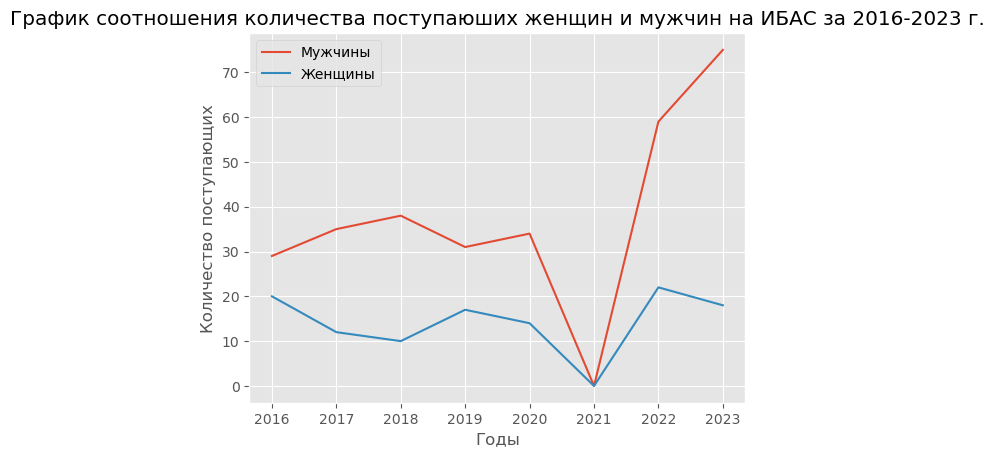

In [132]:
count_male = []
count_female = []
for i in range(2016, 2024):
    count_female1 = data_ibas.loc[(
        (data_ibas['Пол'] == 'Женский') & (data_ibas['Год поступления'] == i))]
    count_female.append(count_female1['Пол'].size)
    count_male1 = data_ibas.loc[((data_ibas['Пол'] == 'Мужской') & (
        data_ibas['Год поступления'] == i))]
    count_male.append(count_male1['Пол'].size)

plt.plot(years, count_male, label='Мужчины')
plt.plot(years, count_female, label='Женщины')
plt.title(
    'График соотношения количества поступаюших женщин и мужчин на ИБАС за 2016-2023 г.')
plt.xlabel('Годы')
plt.ylabel('Количество поступающих')
plt.legend()
plt.show()

In [137]:
list_ = ['Образовательное учереждение', 'р.я', 'мат', '3балл', '3экз', 'Олимпиада', 'Медаль', 'Сумма баллов', 'Год поступления']
data_ibas_shrt = data_ibas[list_]

data_pmi = data_frame.loc[(data_frame['Набор ОП'] == '01.03.02 Прикладная математика и информатика') & (
    data_frame['Вид приема'] == 'Общий конкурс')]
data_pmi_shrt = data_pmi[list_]

data_fiit = data_frame.loc[(data_frame['Набор ОП'] == '02.03.02 Фундаментальная информатика и информационные технологии') & (
    data_frame['Вид приема'] == 'Общий конкурс')]
data_fiit_shrt = data_fiit[list_]

data_ivt = data_frame.loc[(data_frame['Набор ОП'] == '09.03.01 Информатика и вычислительная техника') & (
    data_frame['Вид приема'] == 'Общий конкурс')]
data_ivt_shrt = data_ivt[list_]

In [156]:
def avg_points(data, name):
    points_year = []
    years = []
    for i in range(2016, 2024):
        years.append(i)
        points_temp = data.loc[data['Год поступления'] == i]
        points_temp = points_temp['Сумма баллов'].values
        points_year.append(np.mean(points_temp))

    plt.plot(years, points_year, label=name)
    plt.title('График среднего количества баллов поступаюших на напрaвленияx ИИК за 2016-2023 г.')
    plt.xlabel('Годы')
    plt.ylabel('Количество баллов')
    plt.legend()
    plt.show

def avg_points_subjects(data, name):
    points_fiz_year = []
    points_inf_year = []
    points_rus_year = []
    points_math_year = []
    years = []
    for i in range(2016, 2024):
        years.append(i)
        points_temp = data.loc[data['Год поступления'] == i]
        points_temp_values = points_temp['р.я'].values
        points_rus_year.append(np.mean(points_temp_values))
        points_temp_values = points_temp['мат'].values
        points_math_year.append(np.mean(points_temp_values))
        points_temp_inf = points_temp.loc[points_temp['3экз'] == 'Информатика']
        points_temp_values = points_temp_inf['3балл'].values
        points_inf_year.append(np.mean(points_temp_values))
        points_temp_fiz = points_temp.loc[points_temp['3экз'] == 'Физика']
        points_temp_values = points_temp_fiz['3балл'].values
        points_fiz_year.append(np.mean(points_temp_values))

    plt.figure(figsize=(10, 5))
    plt.plot(years, points_fiz_year, label='Физика')
    plt.plot(years, points_inf_year, label='Информатика')
    plt.plot(years, points_math_year, label='Математика')
    plt.plot(years, points_rus_year, label='Русский язык')
    plt.title(
        f'График средних значений баллов по р.я., мат., физ. и инф. на {name} за 2016-2023 г.')
    plt.xlabel('Годы')
    plt.ylabel('Баллы')
    plt.legend(loc='center right')
    plt.show()

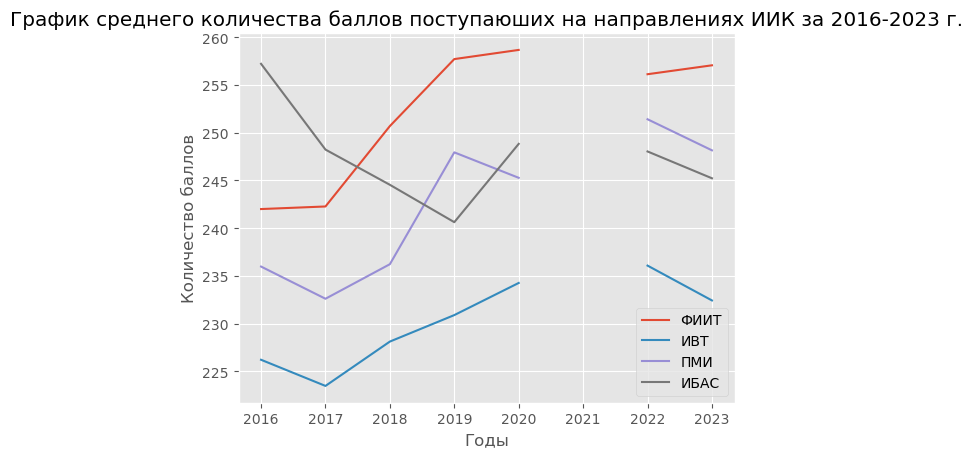

In [157]:
avg_points(data_fiit_shrt, 'ФИИТ')
avg_points(data_ivt_shrt, 'ИВТ')
avg_points(data_pmi_shrt, 'ПМИ')
avg_points(data_ibas, 'ИБАС')

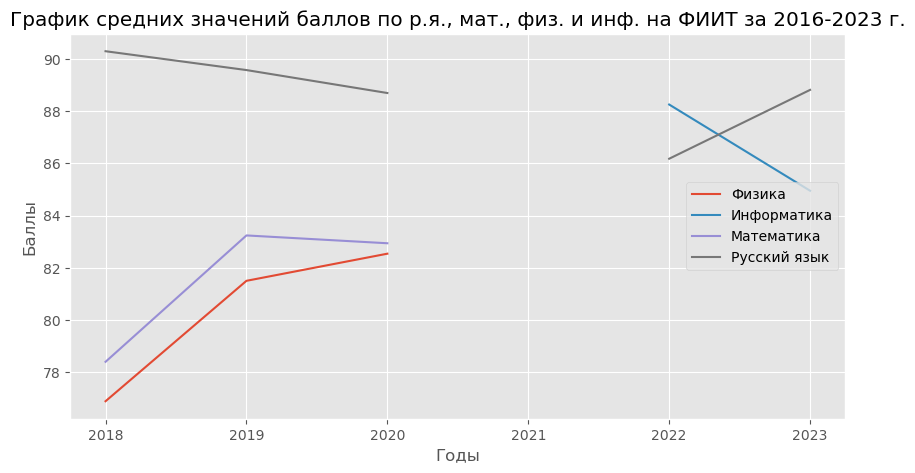

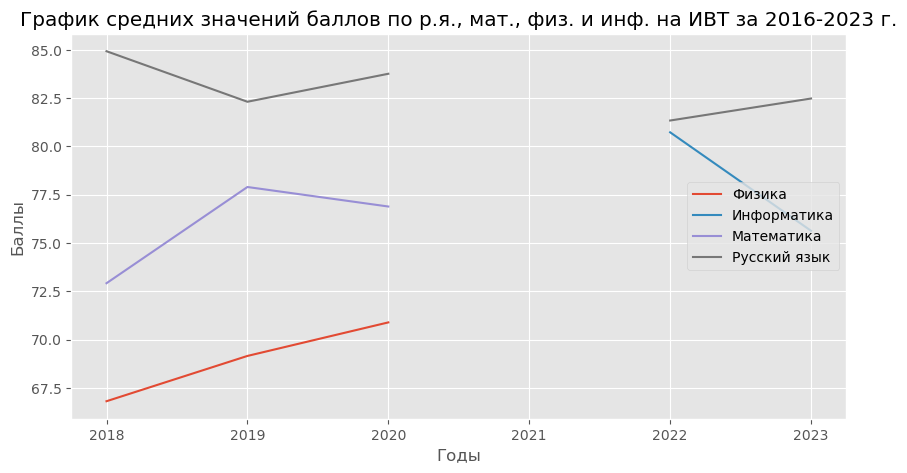

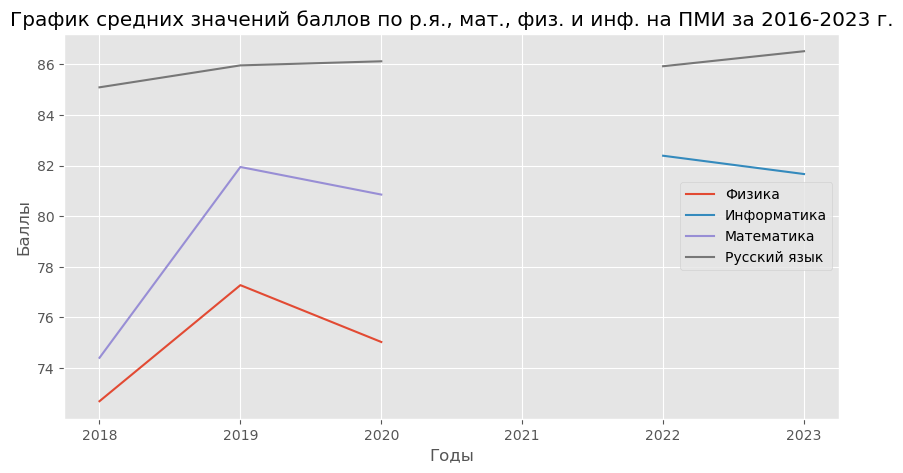

In [158]:
avg_points_subjects(data_fiit_shrt, 'ФИИТ')
avg_points_subjects(data_ivt_shrt, 'ИВТ')
avg_points_subjects(data_pmi_shrt, 'ПМИ')